In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

In [23]:
def load_images(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [24]:
preprocessed_directory = "../data/preprocessed"
preprocessed_images = load_images(preprocessed_directory)
print(f"Loaded {len(preprocessed_images)} preprocessed images.")

Loaded 120 preprocessed images.


In [35]:
def detect_and_match_features(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    return kp1, kp2, good_matches

In [36]:
def estimate_motion(kp1, kp2, matches, min_matches=10):
    if len(matches) < min_matches:
        raise ValueError(f"Not enough matches found: {len(matches)} (minimum required: {min_matches})")
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    if M is None:
        raise ValueError("Homography estimation failed.")
    
    return M

In [28]:
def estimate_motion(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if M is None:
        raise ValueError("Homography estimation failed.")
    return M

In [37]:
def custom_stitch(images, min_matches=10):
    sift = cv2.SIFT_create()
    kp_list = []
    des_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        kp_list.append(kp)
        des_list.append(des)
    
    stitched = images[0]
    for i in range(1, len(images)):
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_list[i-1], des_list[i], k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
        
        try:
            # Estimate the homography matrix with a check for minimum matches
            M = estimate_motion(kp_list[i-1], kp_list[i], good_matches, min_matches=min_matches)
        except ValueError as e:
            print(f"Skipping image {i} due to error: {e}")
            continue  # Skip this image if there are not enough matches or if homography fails
        
        # Convert the matrix to float32 if necessary
        M = M.astype(np.float32)
        
        # Resize the next image to match the stitched image height
        h1, w1 = stitched.shape[:2]
        img_resized = cv2.resize(images[i], (images[i].shape[1], h1))  # Match the height of the stitched image
        
        # Warp the next image based on the homography matrix
        stitched = cv2.warpPerspective(stitched, M, (stitched.shape[1] + img_resized.shape[1], h1))
        
        # Place the next image on the canvas
        stitched[0:h1, w1:w1+img_resized.shape[1]] = img_resized
    
    return stitched

Skipping image 2 due to error: Not enough matches found: 8 (minimum required: 15)
Skipping image 3 due to error: Not enough matches found: 10 (minimum required: 15)
Skipping image 5 due to error: Not enough matches found: 8 (minimum required: 15)
Skipping image 6 due to error: Not enough matches found: 10 (minimum required: 15)
Skipping image 8 due to error: Not enough matches found: 13 (minimum required: 15)
Skipping image 9 due to error: Not enough matches found: 12 (minimum required: 15)
Skipping image 10 due to error: Not enough matches found: 12 (minimum required: 15)
Skipping image 11 due to error: Not enough matches found: 14 (minimum required: 15)
Skipping image 12 due to error: Not enough matches found: 5 (minimum required: 15)
Skipping image 18 due to error: Not enough matches found: 14 (minimum required: 15)
Skipping image 19 due to error: Not enough matches found: 8 (minimum required: 15)
Skipping image 22 due to error: Not enough matches found: 7 (minimum required: 15)
Ski

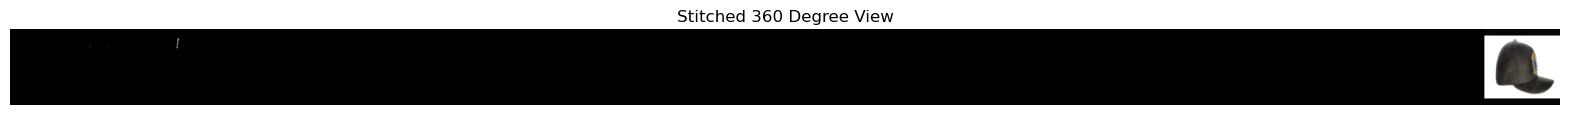

Saved stitched image to ../output/stitched_image.jpg


In [38]:
try:
    stitched_image = custom_stitch([cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in preprocessed_images_subset], min_matches=15)
except Exception as e:
    print(f"Error during stitching: {e}")
finally:
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

if stitched_image is not None and execution_time <= max_execution_time:
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
    plt.title("Stitched 360 Degree View")
    plt.axis('off')
    plt.show()
    
    cv2.imwrite("../output/stitched_image.jpg", stitched_image)
    print("Saved stitched image to ../output/stitched_image.jpg")
else:
    print("Stitching failed or took too long. Try with fewer images or lower resolution.")